In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil

In [2]:
DATASET_PATH = '/home/shahriar/Documents/AideCare/app/dataset/kaggle_3m'
OUTPUT_PATH = 'yolo_dataset'

In [3]:
os.makedirs(os.path.join(OUTPUT_PATH, 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, 'images', 'val'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, 'labels', 'train'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, 'labels', 'val'), exist_ok=True)

In [4]:
image_paths = []
mask_paths = []

for patient_folder in os.listdir(DATASET_PATH):
    patient_path = os.path.join(DATASET_PATH, patient_folder)
    if os.path.isdir(patient_path):
        for file_name in os.listdir(patient_path):
            if file_name.endswith('.tif') and '_mask.tif' not in file_name:
                image_path = os.path.join(patient_path, file_name)
                mask_name = file_name.replace('.tif', '_mask.tif')
                mask_path = os.path.join(patient_path, mask_name)
                if os.path.exists(mask_path):
                    image_paths.append(image_path)
                    mask_paths.append(mask_path)
                else:
                    print(f"Warning: Mask not found for {image_path}")

In [5]:
train_images, val_images, train_masks, val_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

In [6]:
def process_dataset(image_list, mask_list, type_str):
    for i in range(len(image_list)):
        img_path = image_list[i]
        msk_path = mask_list[i]

        try:
            img = Image.open(img_path)
            msk = Image.open(msk_path).convert('L')
            img_np = np.array(img)
            msk_np = np.array(msk)
        except Exception as e:
            print(f"Error: Loading image or mask {img_path}: {e}")
            continue

        H, W = msk_np.shape
        contours, _ = cv2.findContours(msk_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        label_file_content = []

        for contour in contours:
            if contour.shape[0] > 2:
                segment = contour.reshape(-1, 2)
                normalized_segment = segment / np.array([W, H])
                segment_str = ' '.join([f'{coord:.6f}' for coord in normalized_segment.flatten()])
                label_file_content.append(f'0 {segment_str}')
        base_name = os.path.basename(img_path).replace('.tif', '')
        label_output_path = os.path.join(OUTPUT_PATH, 'labels', type_str, f'{base_name}.txt')
        with open(label_output_path, 'w') as f:
            for line in label_file_content:
                f.write(line + '\n')
        
        shutil.copy(img_path, os.path.join(OUTPUT_PATH, 'images', type_str, os.path.basename(img_path)))
        print(f'Processe: {base_name} for {type_str}')
        
    

In [7]:
print("Processing training data...")
process_dataset(train_images, train_masks, 'train')
print("Processing validation data...")
process_dataset(val_images, val_masks, 'val')

print(f"Dataset preparation complete. Check '{OUTPUT_PATH}' directory.")

with open(os.path.join(OUTPUT_PATH, 'dataset.yaml'), 'w') as f:
    f.write("path: ../yolo_dataset\n")
    f.write("train: images/train\n")
    f.write("val: images/val\n")
    f.write("names:\n")
    f.write("  0: tumor\n")
print(f"Generated dataset.yaml in '{OUTPUT_PATH}'.")

Processing training data...
Processe: TCGA_CS_6666_20011109_19 for train
Processe: TCGA_DU_5852_19950709_27 for train
Processe: TCGA_FG_7637_20000922_47 for train
Processe: TCGA_HT_8114_19981030_3 for train
Processe: TCGA_DU_7300_19910814_26 for train
Processe: TCGA_HT_7608_19940304_5 for train
Processe: TCGA_HT_8105_19980826_19 for train
Processe: TCGA_DU_6400_19830518_56 for train
Processe: TCGA_CS_6668_20011025_13 for train
Processe: TCGA_DU_6407_19860514_54 for train
Processe: TCGA_CS_5393_19990606_19 for train
Processe: TCGA_FG_A60K_20040224_26 for train
Processe: TCGA_FG_6689_20020326_11 for train
Processe: TCGA_FG_5964_20010511_14 for train
Processe: TCGA_FG_7643_20021104_9 for train
Processe: TCGA_FG_7634_20000128_6 for train
Processe: TCGA_HT_8106_19970727_1 for train
Processe: TCGA_FG_A60K_20040224_17 for train
Processe: TCGA_HT_8111_19980330_8 for train
Processe: TCGA_DU_7294_19890104_3 for train
Processe: TCGA_HT_8111_19980330_2 for train
Processe: TCGA_DU_5849_19950405_1 f

In [8]:
from ultralytics import YOLO

DATA_YAML_PATH = OUTPUT_PATH + '/dataset.yaml'

model = YOLO('yolo11m-seg.pt')

100%|██████████| 43.3M/43.3M [00:54<00:00, 827kB/s] 


In [9]:
print(f"Attempting to load data from: {DATA_YAML_PATH}")

results = model.train(
    data=DATA_YAML_PATH,
    epochs=100,
    imgsz=256,
    batch=16,
    name='yolov11_seg_tumor',
    device='0'
)

print('Processed: Model successfully trained.')

Attempting to load data from: yolo_dataset/dataset.yaml
Ultralytics 8.3.168 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 3755MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11_seg_tumor, nbs=64, nms=False, opset=None, optimize=False, optim

100%|██████████| 5.35M/5.35M [00:07<00:00, 724kB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5441.4±1308.0 MB/s, size: 198.3 KB)


train: Scanning /home/shahriar/Documents/AideCare/app/yolo_dataset/labels/train... 3143 images, 2036 backgrounds, 0 corrupt: 100%|██████████| 3143/3143 [00:01<00:00, 2990.45it/s]

train: New cache created: /home/shahriar/Documents/AideCare/app/yolo_dataset/labels/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2126.3±920.2 MB/s, size: 198.3 KB)


val: Scanning /home/shahriar/Documents/AideCare/app/yolo_dataset/labels/val... 786 images, 520 backgrounds, 0 corrupt: 100%|██████████| 786/786 [00:00<00:00, 2254.30it/s]

val: New cache created: /home/shahriar/Documents/AideCare/app/yolo_dataset/labels/val.cache


Plotting labels to runs/segment/yolov11_seg_tumor/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to runs/segment/yolov11_seg_tumor
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.85G      1.619      2.784      1.911      1.395          5        256: 100%|██████████| 197/197 [00:49<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.97it/s]


                   all        786        292   7.24e-05     0.0137   3.18e-05   5.07e-06          0          0          0          0

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.98G      1.783      2.869      1.613      1.513          4        256: 100%|██████████| 197/197 [00:47<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.99it/s]


                   all        786        292     0.0221      0.479     0.0132    0.00601     0.0197       0.36     0.0112    0.00493

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.99G      1.667      2.635      1.437      1.461          5        256: 100%|██████████| 197/197 [00:46<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  3.97it/s]

                   all        786        292      0.654      0.545      0.544      0.305      0.648       0.53       0.52      0.284



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.99G      1.661      2.633      1.401      1.454          2        256: 100%|██████████| 197/197 [00:47<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]

                   all        786        292      0.758      0.616      0.676      0.409      0.726       0.61      0.661      0.375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.02G      1.571      2.455      1.246      1.383          4        256: 100%|██████████| 197/197 [00:46<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.03it/s]

                   all        786        292      0.818      0.545      0.629      0.363      0.776      0.538      0.601      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.98G      1.528      2.423      1.264      1.366          8        256: 100%|██████████| 197/197 [00:46<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.09it/s]

                   all        786        292      0.837      0.627      0.727      0.421      0.827       0.62      0.697      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100         2G      1.485      2.347       1.18       1.36          8        256: 100%|██████████| 197/197 [00:46<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.08it/s]

                   all        786        292      0.824      0.682      0.743      0.459      0.808      0.671      0.718      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100         2G       1.47       2.35       1.15      1.324          5        256: 100%|██████████| 197/197 [00:45<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.03it/s]

                   all        786        292      0.805      0.692      0.743      0.459      0.829       0.64      0.708      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100         2G      1.459      2.298       1.11      1.326          2        256: 100%|██████████| 197/197 [00:46<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.03it/s]

                   all        786        292      0.837      0.699      0.748      0.447      0.817      0.671      0.713       0.41



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.98G      1.375      2.198      1.035      1.276          2        256: 100%|██████████| 197/197 [00:45<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]

                   all        786        292      0.869       0.63      0.737      0.471      0.857      0.616      0.712      0.418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100         2G      1.337      2.112     0.9823      1.264          4        256: 100%|██████████| 197/197 [00:47<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.00it/s]

                   all        786        292       0.85      0.678      0.759      0.478      0.822      0.651      0.709      0.419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.99G       1.36      2.156       1.01      1.257          6        256: 100%|██████████| 197/197 [00:46<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.02it/s]

                   all        786        292      0.822      0.675      0.738      0.474      0.811      0.664      0.704      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100         2G      1.378      2.121     0.9762      1.284          7        256: 100%|██████████| 197/197 [00:46<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]

                   all        786        292      0.844      0.705      0.766      0.495       0.81      0.675       0.72      0.445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.98G      1.317      2.151     0.9657      1.254         11        256: 100%|██████████| 197/197 [00:46<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]

                   all        786        292      0.818      0.722      0.766      0.481      0.801      0.695      0.731      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100         2G      1.311       2.08     0.9476      1.248         11        256: 100%|██████████| 197/197 [00:46<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.10it/s]

                   all        786        292      0.854      0.743      0.794      0.518       0.86      0.688      0.753      0.464



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100         2G      1.282      2.042     0.8969       1.24          3        256: 100%|██████████| 197/197 [00:45<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.13it/s]

                   all        786        292       0.84      0.685      0.753      0.487      0.862      0.654      0.719      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.99G      1.271      1.979      0.867      1.224          6        256: 100%|██████████| 197/197 [00:46<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.05it/s]

                   all        786        292      0.862      0.716      0.792       0.52      0.848      0.688      0.755      0.455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.99G      1.302       2.06     0.9198      1.236          4        256: 100%|██████████| 197/197 [00:45<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.00it/s]

                   all        786        292      0.889       0.76      0.811      0.522      0.854      0.747      0.782      0.462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.99G      1.295      2.067     0.8804      1.227          4        256: 100%|██████████| 197/197 [00:46<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]

                   all        786        292      0.854      0.721      0.777      0.509       0.83      0.702      0.752      0.458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100         2G      1.205      1.965       0.83      1.188          1        256: 100%|██████████| 197/197 [00:46<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.11it/s]

                   all        786        292      0.873      0.726      0.819       0.55      0.892      0.675      0.773      0.467



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.99G      1.249       2.03     0.9033      1.219          3        256: 100%|██████████| 197/197 [00:46<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.15it/s]

                   all        786        292      0.915      0.723       0.83      0.578      0.899      0.709      0.795      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.97G      1.214      1.947     0.8388       1.21          3        256: 100%|██████████| 197/197 [00:46<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]

                   all        786        292      0.906      0.753      0.827      0.565      0.886      0.736      0.792      0.489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.99G      1.216      1.939     0.8158      1.186          2        256: 100%|██████████| 197/197 [00:45<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]

                   all        786        292      0.846      0.709      0.786       0.54      0.863      0.691       0.76      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100         2G      1.205      1.944     0.8062      1.184          4        256: 100%|██████████| 197/197 [00:45<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.09it/s]

                   all        786        292      0.892      0.709      0.787      0.512      0.883      0.671      0.742      0.438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100         2G      1.206       1.93     0.8299      1.189          5        256: 100%|██████████| 197/197 [00:46<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.07it/s]

                   all        786        292      0.869       0.75      0.816      0.542      0.845       0.73      0.773      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.98G      1.207       1.89     0.7903      1.181          4        256: 100%|██████████| 197/197 [00:47<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.11it/s]

                   all        786        292       0.89      0.729      0.813      0.551      0.862      0.682      0.781      0.481



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.99G      1.158      1.854     0.7746      1.167          5        256: 100%|██████████| 197/197 [00:45<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]

                   all        786        292      0.865      0.774      0.833      0.566      0.846      0.729      0.778      0.498



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.99G      1.163      1.846     0.7486      1.165          2        256: 100%|██████████| 197/197 [00:46<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]

                   all        786        292      0.887      0.723      0.818      0.565      0.866      0.706      0.791      0.499



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.03G      1.188      1.879     0.8019       1.17          3        256: 100%|██████████| 197/197 [00:46<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.14it/s]

                   all        786        292      0.868      0.724      0.798      0.531      0.856      0.705      0.766       0.46



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.97G      1.136      1.778     0.7551      1.143          3        256: 100%|██████████| 197/197 [00:46<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]

                   all        786        292      0.904      0.739      0.827      0.568      0.897      0.716      0.795      0.493



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100         2G      1.154      1.853     0.7607      1.157          7        256: 100%|██████████| 197/197 [00:46<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]

                   all        786        292      0.891      0.729      0.808       0.56      0.874      0.716      0.781      0.488



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.99G      1.162      1.865     0.7477      1.162          2        256: 100%|██████████| 197/197 [00:46<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]

                   all        786        292      0.851      0.782      0.846      0.577      0.818      0.753      0.798      0.485



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100         2G      1.119      1.869     0.7234       1.15          7        256: 100%|██████████| 197/197 [00:45<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]

                   all        786        292      0.937      0.715      0.824      0.569       0.92      0.699      0.786      0.489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.97G      1.163      1.811     0.7453      1.153          2        256: 100%|██████████| 197/197 [00:46<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.06it/s]

                   all        786        292      0.887      0.723      0.821      0.564      0.872      0.705      0.787      0.505



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.99G      1.099      1.791     0.7055       1.14          2        256: 100%|██████████| 197/197 [00:46<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.15it/s]

                   all        786        292      0.919      0.738      0.842      0.582      0.873      0.723      0.807      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.99G      1.123      1.836     0.7275      1.146          4        256: 100%|██████████| 197/197 [00:46<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.13it/s]

                   all        786        292        0.9       0.76      0.846        0.6      0.881      0.736      0.813      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100         2G       1.12      1.786     0.7038      1.138          3        256: 100%|██████████| 197/197 [00:46<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.15it/s]

                   all        786        292       0.91      0.765      0.842      0.579      0.899      0.735       0.81       0.51



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.98G      1.126      1.806      0.701      1.129          3        256: 100%|██████████| 197/197 [00:46<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.17it/s]

                   all        786        292      0.901      0.723      0.819      0.575      0.888      0.712      0.806      0.509



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100         2G      1.103      1.812     0.7271      1.117          5        256: 100%|██████████| 197/197 [00:47<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.17it/s]

                   all        786        292      0.894      0.752      0.839      0.577      0.888      0.723      0.801      0.512



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100         2G      1.077      1.731     0.6865       1.12          4        256: 100%|██████████| 197/197 [00:46<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.15it/s]

                   all        786        292      0.899      0.747      0.836      0.589      0.891      0.736      0.806      0.503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.99G      1.089      1.793     0.6997      1.125          9        256: 100%|██████████| 197/197 [00:46<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]

                   all        786        292        0.9      0.726      0.813      0.564      0.907      0.701      0.787      0.498



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.99G      1.098      1.761     0.6799      1.122          1        256: 100%|██████████| 197/197 [00:46<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.14it/s]

                   all        786        292      0.851      0.782      0.843      0.571      0.844      0.747      0.801      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.99G      1.094      1.754     0.6742      1.135          7        256: 100%|██████████| 197/197 [00:45<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.13it/s]

                   all        786        292      0.929      0.719      0.842      0.597      0.898      0.695      0.798      0.506



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100         2G      1.059      1.669     0.6791      1.109          5        256: 100%|██████████| 197/197 [00:46<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]

                   all        786        292       0.93      0.709      0.832      0.606      0.906      0.709      0.809      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.02G      1.076      1.767     0.6692      1.127          5        256: 100%|██████████| 197/197 [00:46<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]

                   all        786        292       0.91      0.733      0.841      0.594      0.893      0.716      0.812      0.525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.98G      1.046      1.686      0.659      1.095          1        256: 100%|██████████| 197/197 [00:46<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.17it/s]

                   all        786        292      0.868      0.767      0.841        0.6      0.909      0.715       0.81      0.524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.99G      1.082      1.698       0.66      1.124          3        256: 100%|██████████| 197/197 [00:46<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]

                   all        786        292       0.91      0.766      0.845      0.606      0.888      0.743      0.808      0.517



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.99G       1.05      1.678     0.6474      1.101          3        256: 100%|██████████| 197/197 [00:46<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]

                   all        786        292      0.924      0.751      0.857      0.593      0.911      0.734      0.818      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100         2G      1.083      1.719     0.6653      1.126          7        256: 100%|██████████| 197/197 [00:46<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.12it/s]

                   all        786        292      0.914      0.764      0.847      0.581      0.898      0.723      0.792      0.501



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.97G      1.059      1.662       0.67      1.113          3        256: 100%|██████████| 197/197 [00:47<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]

                   all        786        292      0.853      0.781      0.849      0.592      0.901      0.719      0.813      0.521



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.99G       1.04      1.717     0.6436      1.102          3        256: 100%|██████████| 197/197 [00:46<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.08it/s]

                   all        786        292       0.93      0.747      0.835      0.595      0.904      0.726      0.804      0.508



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.99G      1.023       1.64     0.6344        1.1          5        256: 100%|██████████| 197/197 [00:46<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]

                   all        786        292      0.903      0.764      0.855      0.599      0.891      0.755      0.827      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.03G      1.042       1.73     0.6394      1.104          4        256: 100%|██████████| 197/197 [00:46<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]

                   all        786        292       0.88       0.78      0.856      0.592      0.853      0.756      0.822      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.98G      1.004      1.641     0.6382      1.079          3        256: 100%|██████████| 197/197 [00:46<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]

                   all        786        292      0.894      0.753      0.838      0.599      0.874      0.736      0.805      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.99G      1.008      1.651     0.6323      1.077          5        256: 100%|██████████| 197/197 [00:46<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]

                   all        786        292      0.909      0.754      0.857      0.598      0.914      0.729      0.821      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.99G      1.017      1.605     0.6222      1.075         10        256: 100%|██████████| 197/197 [00:46<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.16it/s]

                   all        786        292      0.899      0.762      0.856      0.602      0.889      0.729      0.824      0.527



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.99G      1.022      1.633     0.6206      1.081          5        256: 100%|██████████| 197/197 [00:45<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]

                   all        786        292      0.892      0.767      0.856      0.609       0.88      0.751      0.812      0.524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.97G          1      1.615     0.6038      1.068          2        256: 100%|██████████| 197/197 [00:47<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.14it/s]

                   all        786        292      0.914      0.747       0.85      0.604      0.914      0.747      0.833      0.526



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.99G     0.9854      1.597     0.6059      1.065          7        256: 100%|██████████| 197/197 [00:46<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.15it/s]

                   all        786        292      0.896      0.791      0.853      0.609       0.92      0.729      0.822      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.99G     0.9538      1.579     0.5951      1.075          8        256: 100%|██████████| 197/197 [00:46<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]

                   all        786        292      0.959      0.757      0.861      0.617      0.941       0.74      0.832       0.53



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.99G     0.9743      1.602     0.6004      1.069          4        256: 100%|██████████| 197/197 [00:47<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]

                   all        786        292      0.925       0.76      0.865      0.617      0.907      0.737      0.834      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.98G     0.9806      1.608     0.5933      1.069          6        256: 100%|██████████| 197/197 [00:46<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]

                   all        786        292      0.922      0.764      0.871      0.615      0.915      0.753      0.849      0.529



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.99G     0.9887      1.597     0.6133      1.082          2        256: 100%|██████████| 197/197 [00:47<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]

                   all        786        292      0.921      0.756      0.868      0.605      0.901      0.736      0.832      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.99G      1.011      1.649      0.624      1.081          4        256: 100%|██████████| 197/197 [00:47<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]

                   all        786        292      0.918      0.771      0.865      0.614      0.854      0.781      0.838      0.533



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.99G     0.9604      1.556     0.5869      1.066          3        256: 100%|██████████| 197/197 [00:46<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.23it/s]

                   all        786        292      0.937      0.757      0.856      0.606      0.928      0.745      0.842      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.99G      1.007      1.567     0.5872      1.065          7        256: 100%|██████████| 197/197 [00:46<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]

                   all        786        292      0.864      0.785      0.857      0.614      0.857       0.78      0.839      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.99G     0.9779       1.59     0.5756      1.088          7        256: 100%|██████████| 197/197 [00:46<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]

                   all        786        292      0.866      0.795      0.874      0.632      0.919      0.735      0.857      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.99G     0.9593      1.541     0.5703       1.05          5        256: 100%|██████████| 197/197 [00:46<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.23it/s]

                   all        786        292      0.897      0.778      0.863      0.618      0.916       0.74      0.832      0.541



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.99G     0.9697      1.605     0.5622      1.067          7        256: 100%|██████████| 197/197 [00:47<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]

                   all        786        292      0.874      0.801      0.863      0.609      0.848      0.777      0.823      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.98G     0.9443      1.527     0.5558      1.047          7        256: 100%|██████████| 197/197 [00:46<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]

                   all        786        292      0.876      0.795      0.867      0.614      0.923      0.716      0.829      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100         2G     0.9348      1.524      0.546       1.05          9        256: 100%|██████████| 197/197 [00:46<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]

                   all        786        292      0.914      0.774      0.869       0.62      0.898       0.76      0.842       0.54



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100         2G     0.9307      1.515      0.543      1.024          4        256: 100%|██████████| 197/197 [00:46<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]

                   all        786        292      0.928       0.76      0.874      0.629      0.932       0.75      0.859      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.99G     0.9306      1.523     0.5382      1.039          2        256: 100%|██████████| 197/197 [00:47<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.18it/s]

                   all        786        292       0.88      0.774      0.872      0.626      0.932      0.723      0.835      0.538



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.97G     0.9137      1.531     0.5313      1.054          5        256: 100%|██████████| 197/197 [00:46<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:06<00:00,  4.15it/s]

                   all        786        292      0.896      0.771      0.862      0.617      0.913      0.743      0.831      0.535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.99G     0.9482      1.543      0.563      1.051          7        256: 100%|██████████| 197/197 [00:46<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.23it/s]

                   all        786        292      0.929      0.766      0.867      0.622      0.909      0.749      0.834      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100         2G     0.9251      1.535     0.5624      1.053          2        256: 100%|██████████| 197/197 [00:46<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]

                   all        786        292      0.904      0.744      0.855      0.615      0.901      0.729      0.827      0.524



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100         2G     0.9456       1.54     0.5497      1.053          4        256: 100%|██████████| 197/197 [00:47<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]

                   all        786        292      0.914      0.781      0.866      0.623      0.894      0.764      0.837      0.535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.98G     0.9102      1.509     0.5473      1.038          5        256: 100%|██████████| 197/197 [00:46<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]

                   all        786        292      0.921       0.76      0.859      0.616      0.903      0.743      0.827      0.531



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100         2G     0.9019      1.521       0.53       1.01          5        256: 100%|██████████| 197/197 [00:46<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.17it/s]

                   all        786        292      0.917      0.781      0.876      0.628      0.893       0.76      0.841      0.542



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.99G     0.9108      1.544     0.5341      1.041          6        256: 100%|██████████| 197/197 [00:46<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]

                   all        786        292      0.898      0.783      0.871      0.632      0.887      0.776      0.852      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100         2G     0.9064      1.478     0.5092       1.04          2        256: 100%|██████████| 197/197 [00:46<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.22it/s]

                   all        786        292      0.914      0.774      0.874      0.636      0.906      0.767      0.862      0.552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.98G      0.896      1.504     0.5171      1.039          9        256: 100%|██████████| 197/197 [00:46<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.23it/s]

                   all        786        292      0.925      0.784      0.883      0.634      0.917       0.76      0.842      0.543



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.99G     0.9335      1.515     0.5375      1.042          6        256: 100%|██████████| 197/197 [00:46<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.22it/s]

                   all        786        292      0.928      0.774      0.872      0.638       0.92      0.767      0.847       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100         2G     0.8844      1.464     0.5192      1.029          5        256: 100%|██████████| 197/197 [00:46<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]

                   all        786        292      0.851      0.829      0.869      0.625      0.921      0.747      0.831      0.544



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.99G     0.8857      1.448     0.4989      1.032          4        256: 100%|██████████| 197/197 [00:46<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.22it/s]

                   all        786        292      0.915      0.795       0.87      0.632      0.899      0.763      0.845       0.54



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.99G     0.8731      1.466      0.508      1.026          8        256: 100%|██████████| 197/197 [00:46<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]

                   all        786        292      0.909      0.786      0.869      0.637      0.918       0.77       0.85      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100         2G     0.8734      1.494     0.5107      1.017          2        256: 100%|██████████| 197/197 [00:46<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.20it/s]

                   all        786        292      0.905      0.774      0.878      0.643      0.923       0.75      0.844       0.54



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.99G     0.8905      1.459      0.519      1.028          5        256: 100%|██████████| 197/197 [00:45<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.19it/s]

                   all        786        292      0.921       0.76      0.867      0.634      0.914       0.75      0.834      0.544



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.99G     0.9103      1.462     0.5249      1.028          7        256: 100%|██████████| 197/197 [00:46<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.23it/s]

                   all        786        292      0.917      0.764      0.875      0.638      0.924      0.743      0.849      0.549



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.97G     0.8802      1.479     0.5053      1.017          3        256: 100%|██████████| 197/197 [00:46<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]

                   all        786        292      0.914       0.76      0.873      0.638      0.901       0.75      0.846      0.546


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.99G     0.8669      1.498     0.4992      1.071          1        256: 100%|██████████| 197/197 [00:46<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.24it/s]

                   all        786        292      0.877      0.805      0.876      0.632      0.931      0.747      0.853      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.99G     0.8535      1.454     0.4897      1.061          2        256: 100%|██████████| 197/197 [00:46<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.23it/s]

                   all        786        292      0.888      0.795      0.877       0.64      0.924      0.753      0.857       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.99G     0.8583      1.452     0.4809      1.056          2        256: 100%|██████████| 197/197 [00:45<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.23it/s]

                   all        786        292      0.889      0.795      0.879      0.639      0.879      0.772      0.847      0.552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.97G     0.8263      1.434     0.4722      1.046          4        256: 100%|██████████| 197/197 [00:46<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.22it/s]

                   all        786        292      0.902      0.791      0.884       0.64      0.918      0.757      0.857       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.98G     0.8404      1.437     0.4794      1.043          3        256: 100%|██████████| 197/197 [00:46<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.23it/s]

                   all        786        292      0.932      0.777      0.879      0.639      0.915      0.764      0.851      0.554



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.99G     0.8343      1.426     0.4717      1.044          2        256: 100%|██████████| 197/197 [00:45<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.25it/s]

                   all        786        292       0.86       0.82      0.883      0.647      0.925      0.755       0.86      0.562



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.98G     0.8193      1.414     0.4533      1.031          4        256: 100%|██████████| 197/197 [00:46<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.23it/s]

                   all        786        292      0.896        0.8      0.885      0.652      0.886      0.775      0.859      0.557



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.99G      0.803      1.449      0.456      1.042          2        256: 100%|██████████| 197/197 [00:46<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.23it/s]

                   all        786        292      0.892      0.795      0.882      0.647      0.897      0.777      0.856      0.552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.99G     0.8253      1.431     0.4694      1.046          3        256: 100%|██████████| 197/197 [00:46<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]

                   all        786        292      0.893      0.795      0.884      0.651      0.893      0.773      0.857      0.553



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.99G     0.8156      1.403     0.4628      1.042          1        256: 100%|██████████| 197/197 [00:46<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.21it/s]

                   all        786        292      0.879      0.823      0.888      0.645      0.883      0.777      0.856      0.555



100 epochs completed in 1.477 hours.
Optimizer stripped from runs/segment/yolov11_seg_tumor/weights/last.pt, 45.1MB
Optimizer stripped from runs/segment/yolov11_seg_tumor/weights/best.pt, 45.1MB

Validating runs/segment/yolov11_seg_tumor/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 3755MiB)
YOLO11m-seg summary (fused): 138 layers, 22,336,083 parameters, 0 gradients, 123.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.88it/s]


                   all        786        292       0.86       0.82      0.883      0.646      0.925      0.755      0.861      0.562
Speed: 0.1ms preprocess, 4.9ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/segment/yolov11_seg_tumor
Processed: Model successfully trained.


In [ ]:
TRAINED_MODEL_PATH = 'runs/segment/yolov11_seg_tumor/weights/best.pt'
FINAL_MODEL_PATH = 'model/'
os.mkdir('model/')
shutil.copy(TRAINED_MODEL_PATH, FINAL_MODEL_PATH)

'model/best.pt'

In [4]:
from ultralytics import YOLO

FINAL_MODEL_PATH = 'model/best.pt'
model = YOLO(FINAL_MODEL_PATH)

Columns in CSV: ['epoch', 'time', 'train/box_loss', 'train/seg_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(M)', 'metrics/recall(M)', 'metrics/mAP50(M)', 'metrics/mAP50-95(M)', 'val/box_loss', 'val/seg_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


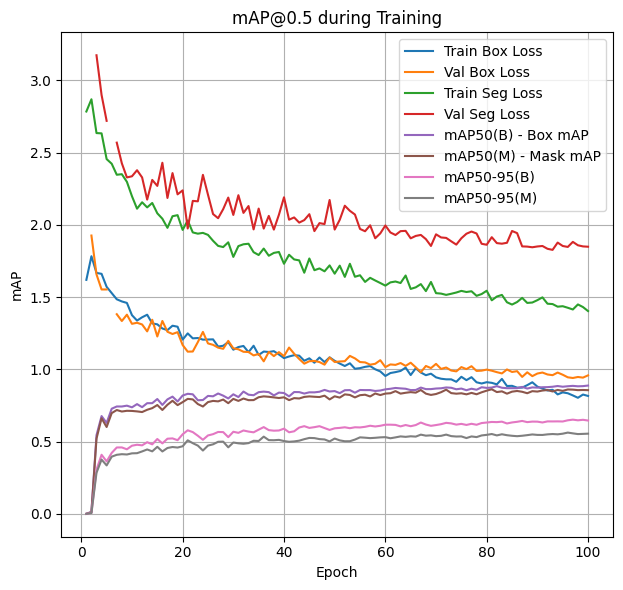


Data in results.csv:
    epoch     time  train/box_loss  train/seg_loss  train/cls_loss  \
95     96  5107.13         0.83429         1.42599         0.47167   
96     97  5159.90         0.81928         1.41409         0.45328   
97     98  5212.68         0.80295         1.44897         0.45598   
98     99  5265.54         0.82531         1.43083         0.46943   
99    100  5318.26         0.81563         1.40303         0.46277   

    train/dfl_loss  metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
95         1.04409               0.85995            0.82015           0.88284   
96         1.03053               0.89644            0.80040           0.88544   
97         1.04222               0.89233            0.79470           0.88243   
98         1.04646               0.89277            0.79452           0.88361   
99         1.04152               0.87922            0.82269           0.88768   

    metrics/mAP50-95(B)  ...  metrics/recall(M)  metrics/mAP50(M)  \
9

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os

RESULTS_DIR = 'runs/segment/yolov11_seg_tumor/'

RESULTS_CSV_PATH = os.path.join(RESULTS_DIR, 'results.csv')

try:
    df = pd.read_csv(RESULTS_CSV_PATH)
    df.columns = df.columns.str.strip()
    print('Columns in CSV:', df.columns.tolist())

except FileNotFoundError:
    print(f'Error: results.csv not found at {RESULTS_CSV_PATH}')
    print('Please make sure the file path is correct or train was successful.')
    exit()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Box Loss during Training')
plt.legend()
plt.grid(True)

plt.plot(df['epoch'], df['train/seg_loss'], label='Train Seg Loss')
plt.plot(df['epoch'], df['val/seg_loss'], label='Val Seg Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Segmentation Loss during Training')
plt.legend()
plt.grid(True)

plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50(B) - Box mAP')
plt.plot(df['epoch'], df['metrics/mAP50(M)'], label='mAP50(M) - Mask mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP@0.5 during Training')
plt.legend()
plt.grid(True)

plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95(B)')
plt.plot(df['epoch'], df['metrics/mAP50-95(M)'], label='mAP50-95(M)')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP@0.5 during Training')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nData in results.csv:")
print(df.tail())

In [1]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

class YoloProcess:
    def __init__(self, model_path="yolo11m-seg.pt", tumor_class_names=None):
        """
        کلاس برای پردازش تصاویر پزشکی با مدل YOLO
        
        Args:
            model_path (str): مسیر فایل مدل YOLO
            tumor_class_names (list): لیست نام کلاس‌هایی که تومور محسوب می‌شوند
        """
        print(f"Loading model from: {model_path}")
        try:
            self.model = YOLO(model_path)
            print("Model loaded successfully!")
            
            # نمایش کلاس‌های موجود در مدل
            if hasattr(self.model, 'names'):
                print("Available classes in model:")
                for idx, name in self.model.names.items():
                    print(f"  {idx}: {name}")
            
            # تنظیم کلاس‌های تومور - اگر مشخص نشده، خودکار تشخیص داده می‌شود
            if tumor_class_names is None:
                # معمولاً کلاس‌هایی که حاوی tumor, cancer, mass هستند
                self.tumor_class_ids = self._auto_detect_tumor_classes()
            else:
                self.tumor_class_ids = self._get_class_ids_by_names(tumor_class_names)
                
            print(f"Tumor class IDs: {self.tumor_class_ids}")
            
        except Exception as e:
            print(f"Error loading model: {e}")
            raise
    
    def _auto_detect_tumor_classes(self):
        """تشخیص خودکار کلاس‌های مربوط به تومور"""
        tumor_keywords = ['tumor', 'cancer', 'mass', 'lesion', 'malignant']
        tumor_ids = []
        
        if hasattr(self.model, 'names'):
            for idx, name in self.model.names.items():
                name_lower = name.lower()
                if any(keyword in name_lower for keyword in tumor_keywords):
                    tumor_ids.append(idx)
        
        # اگر هیچ کلاس تومور پیدا نشد، از کاربر بپرس
        if not tumor_ids:
            print("No tumor classes found automatically. Please specify tumor class IDs manually.")
            print("Available classes:")
            if hasattr(self.model, 'names'):
                for idx, name in self.model.names.items():
                    print(f"  {idx}: {name}")
            
        return tumor_ids
    
    def _get_class_ids_by_names(self, class_names):
        """دریافت ID کلاس‌ها بر اساس نام"""
        class_ids = []
        if hasattr(self.model, 'names'):
            name_to_id = {name.lower(): idx for idx, name in self.model.names.items()}
            for name in class_names:
                if name.lower() in name_to_id:
                    class_ids.append(name_to_id[name.lower()])
                else:
                    print(f"Warning: Class '{name}' not found in model")
        return class_ids
    
    def set_tumor_classes(self, class_ids):
        """تنظیم دستی کلاس‌های تومور"""
        self.tumor_class_ids = class_ids
        print(f"Tumor class IDs set to: {self.tumor_class_ids}")
    
    def process_image(self, image_path, conf_threshold=0.5):
        """
        پردازش تصویر و تشخیص تومور
        
        Args:
            image_path (str): مسیر تصویر ورودی
            conf_threshold (float): آستانه اطمینان برای تشخیص
            
        Returns:
            results: نتایج تشخیص مدل YOLO
        """
        try:
            print(f"Processing image: {image_path}")
            results = self.model(image_path, conf=conf_threshold)
            return results
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            return None
    
    def _filter_tumor_detections(self, result):
        """فیلتر کردن تشخیص‌ها برای نمایش فقط تومورها"""
        if result.boxes is None:
            return None, None
            
        boxes = result.boxes.xyxy.cpu().numpy()
        confidences = result.boxes.conf.cpu().numpy()
        classes = result.boxes.cls.cpu().numpy().astype(int)
        
        # فیلتر کردن فقط کلاس‌های تومور
        tumor_indices = [i for i, cls in enumerate(classes) if cls in self.tumor_class_ids]
        
        if not tumor_indices:
            return None, None
            
        filtered_boxes = boxes[tumor_indices]
        filtered_confidences = confidences[tumor_indices]
        filtered_classes = classes[tumor_indices]
        
        # فیلتر کردن ماسک‌ها
        filtered_masks = None
        if result.masks is not None:
            all_masks = result.masks.data.cpu().numpy()
            filtered_masks = all_masks[tumor_indices]
            
        return {
            'boxes': filtered_boxes,
            'confidences': filtered_confidences,
            'classes': filtered_classes,
            'masks': filtered_masks
        }, tumor_indices
    
    def draw_detection(self, image_path, results, output_path, save_original=True):
        """
        رسم نتایج تشخیص روی تصویر و ذخیره آن - فقط تومورها
        
        Args:
            image_path (str): مسیر تصویر اصلی
            results: نتایج حاصل از process_image
            output_path (str): مسیر ذخیره تصویر خروجی
            save_original (bool): آیا تصویر اصلی هم ذخیره شود
        """
        try:
            if results is None or len(results) == 0:
                print("No results found for visualization")
                return False
            
            # خواندن تصویر اصلی
            original_image = cv2.imread(image_path)
            if original_image is None:
                print(f"Cannot read image: {image_path}")
                return False
            
            # تبدیل از BGR به RGB برای matplotlib
            original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            annotated_image = original_rgb.copy()
            
            result = results[0]
            
            # فیلتر کردن تشخیص‌ها برای نمایش فقط تومورها
            tumor_data, tumor_indices = self._filter_tumor_detections(result)
            
            if tumor_data is None:
                print("No tumor detected in this image")
                # ذخیره تصویر بدون annotation
                plt.figure(figsize=(10, 5))
                if save_original:
                    plt.subplot(1, 2, 1)
                    plt.imshow(original_rgb)
                    plt.title('Original Image')
                    plt.axis('off')
                    
                    plt.subplot(1, 2, 2)
                    plt.imshow(original_rgb)
                    plt.title('No Tumor Detected')
                    plt.axis('off')
                else:
                    plt.imshow(original_rgb)
                    plt.title('No Tumor Detected')
                    plt.axis('off')
                
                plt.tight_layout()
                plt.savefig(output_path, dpi=300, bbox_inches='tight')
                plt.close()
                return True
            
            # رسم باکس‌های تومور
            boxes = tumor_data['boxes']
            confidences = tumor_data['confidences']
            classes = tumor_data['classes']
            
            for i, (box, conf, cls) in enumerate(zip(boxes, confidences, classes)):
                x1, y1, x2, y2 = box.astype(int)
                
                # رسم مستطیل
                cv2.rectangle(annotated_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
                # اضافه کردن متن
                class_name = self.model.names[cls] if hasattr(self.model, 'names') else f'Class_{cls}'
                label = f'{class_name}: {conf:.2f}'
                cv2.putText(annotated_image, label, (x1, y1-10), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            
            # رسم ماسک‌های سگمنتیشن تومور
            if tumor_data['masks'] is not None:
                masks = tumor_data['masks']
                
                for mask in masks:
                    # تغییر اندازه ماسک به اندازه تصویر اصلی
                    mask_resized = cv2.resize(mask, (original_rgb.shape[1], original_rgb.shape[0]))
                    
                    # ایجاد ماسک رنگی (قرمز با شفافیت)
                    colored_mask = np.zeros_like(original_rgb)
                    colored_mask[:, :, 0] = mask_resized * 255  # کانال قرمز
                    
                    # اعمال ماسک با شفافیت
                    alpha = 0.4
                    annotated_image = cv2.addWeighted(annotated_image, 1-alpha, 
                                                    colored_mask, alpha, 0)
            
            # نمایش و ذخیره نتایج
            plt.figure(figsize=(15, 5))
            
            if save_original:
                plt.subplot(1, 2, 1)
                plt.imshow(original_rgb)
                plt.title('Original Image')
                plt.axis('off')
                
                plt.subplot(1, 2, 2)
                plt.imshow(annotated_image)
                plt.title(f'Tumor Detection ({len(boxes)} found)')
                plt.axis('off')
            else:
                plt.imshow(annotated_image)
                plt.title(f'Tumor Detection ({len(boxes)} found)')
                plt.axis('off')
            
            # ذخیره تصویر
            plt.tight_layout()
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            plt.close()
            
            print(f"Output image saved at: {output_path}")
            return True
            
        except Exception as e:
            print(f"Error in drawing results: {e}")
            return False
    
    def get_detection_info(self, results):
        """
        استخراج اطلاعات تشخیص - فقط تومورها
        
        Args:
            results: نتایج حاصل از process_image
            
        Returns:
            dict: اطلاعات تشخیص شامل تعداد تومور و اطمینان
        """
        if results is None or len(results) == 0:
            return {"tumor_count": 0, "confidences": [], "areas": [], "class_names": []}
        
        result = results[0]
        tumor_data, _ = self._filter_tumor_detections(result)
        
        info = {
            "tumor_count": 0,
            "confidences": [],
            "areas": [],
            "class_names": []
        }
        
        if tumor_data is not None:
            info["tumor_count"] = len(tumor_data['boxes'])
            info["confidences"] = tumor_data['confidences'].tolist()
            
            # محاسبه مساحت باکس‌ها
            for box in tumor_data['boxes']:
                x1, y1, x2, y2 = box
                area = (x2 - x1) * (y2 - y1)
                info["areas"].append(area)
            
            # نام کلاس‌ها
            for cls in tumor_data['classes']:
                class_name = self.model.names[cls] if hasattr(self.model, 'names') else f'Class_{cls}'
                info["class_names"].append(class_name)
        
        return info


def process_medical_images(input_dir="input", output_dir="output", model_path="yolo11m-seg.pt", 
                         tumor_class_names=None):
    """
    پردازش دسته‌ای تصاویر پزشکی
    
    Args:
        input_dir (str): دایرکتوری حاوی تصاویر ورودی
        output_dir (str): دایرکتوری خروجی
        model_path (str): مسیر مدل YOLO
        tumor_class_names (list): نام کلاس‌هایی که تومور محسوب می‌شوند
    """
    
    # ایجاد دایرکتوری خروجی
    Path(output_dir).mkdir(exist_ok=True)
    
    # ایجاد شیء YoloProcess
    yolo_processor = YoloProcess(model_path, tumor_class_names)
    
    # لیست فرمت‌های مجاز
    allowed_extensions = ['.tif', '.tiff', '.jpg', '.jpeg', '.png']
    
    # یافتن تمام فایل‌های تصویری
    image_files = []
    for ext in allowed_extensions:
        image_files.extend(Path(input_dir).glob(f'*{ext}'))
        image_files.extend(Path(input_dir).glob(f'*{ext.upper()}'))
    
    if not image_files:
        print(f"No image files found in directory {input_dir}")
        return
    
    print(f"Found {len(image_files)} image files")
    
    # پردازش هر تصویر
    results_summary = []
    
    for i, image_path in enumerate(image_files, 1):
        print(f"\n--- Processing image {i}/{len(image_files)}: {image_path.name} ---")
        
        # پردازش تصویر
        results = yolo_processor.process_image(str(image_path))
        
        if results is not None:
            # تولید نام فایل خروجی
            output_filename = f"{image_path.stem}_detected.png"
            output_path = Path(output_dir) / output_filename
            
            # رسم و ذخیره نتایج
            success = yolo_processor.draw_detection(
                str(image_path), 
                results, 
                str(output_path)
            )
            
            if success:
                # دریافت اطلاعات تشخیص
                detection_info = yolo_processor.get_detection_info(results)
                detection_info["image_name"] = image_path.name
                detection_info["output_path"] = str(output_path)
                results_summary.append(detection_info)
                
                print(f"✅ Number of tumors detected: {detection_info['tumor_count']}")
                if detection_info['confidences']:
                    avg_conf = np.mean(detection_info['confidences'])
                    print(f"📊 Average confidence: {avg_conf:.3f}")
                    print(f"🏷️ Classes found: {', '.join(detection_info['class_names'])}")
                else:
                    print("✅ No tumor detected (clean scan)")
            else:
                print("❌ Error saving results")
        else:
            print("❌ Error processing image")
    
    # نمایش خلاصه نتایج
    print("\n" + "="*50)
    print("📋 Processing Results Summary:")
    print("="*50)
    
    total_tumors = sum(info['tumor_count'] for info in results_summary)
    processed_images = len(results_summary)
    images_with_tumors = len([info for info in results_summary if info['tumor_count'] > 0])
    
    print(f"📁 Images processed: {processed_images}")
    print(f"🎯 Images with tumors: {images_with_tumors}")
    print(f"🔍 Total tumors detected: {total_tumors}")
    
    if results_summary:
        all_confidences = []
        for info in results_summary:
            all_confidences.extend(info['confidences'])
        
        if all_confidences:
            print(f"📈 Overall average confidence: {np.mean(all_confidences):.3f}")
            print(f"📉 Minimum confidence: {np.min(all_confidences):.3f}")
            print(f"📊 Maximum confidence: {np.max(all_confidences):.3f}")


# مثال استفاده:
if __name__ == "__main__":
    # اگر می‌دانید نام کلاس تومور در مدل چیست، آن را مشخص کنید:
    # tumor_classes = ['tumor', 'malignant']  # یا هر نام دیگری که در مدل دارید
    
    # پردازش دسته‌ای تصاویر
    process_medical_images(
        input_dir="input",
        output_dir="output", 
        model_path="yolo11m-seg.pt",
        tumor_class_names=None  # None برای تشخیص خودکار، یا لیست نام کلاس‌ها
    )
    
    # مثال استفاده تک تصویر:
    """
    yolo_proc = YoloProcess("yolo11m-seg.pt")
    
    # اگر نیاز به تنظیم دستی کلاس‌های تومور دارید:
    # yolo_proc.set_tumor_classes([1, 2])  # ID های کلاس‌های تومور
    
    results = yolo_proc.process_image("input/sample_mri.tif")
    yolo_proc.draw_detection("input/sample_mri.tif", results, "output/result.png")
    """

Loading model from: yolo11m-seg.pt
Model loaded successfully!
Available classes in model:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handbag
  27: tie
  28: suitcase
  29: frisbee
  30: skis
  31: snowboard
  32: sports ball
  33: kite
  34: baseball bat
  35: baseball glove
  36: skateboard
  37: surfboard
  38: tennis racket
  39: bottle
  40: wine glass
  41: cup
  42: fork
  43: knife
  44: spoon
  45: bowl
  46: banana
  47: apple
  48: sandwich
  49: orange
  50: broccoli
  51: carrot
  52: hot dog
  53: pizza
  54: donut
  55: cake
  56: chair
  57: couch
  58: potted plant
  59: bed
  60: dining table
  61: toilet
  62: tv
  63: laptop
  64: mouse
  65: remote
  66: keyboard
  67: c

In [17]:
import torch
from ultralytics import YOLO
import cv2
import numpy as np

# مسیر وزن های بهترین مدل آموزش دیده شما
# این مسیر رو بر اساس نامی که در مرحله آموزش دادید، تنظیم کنید.
TRAINED_MODEL_PATH = 'best.pt'

# مسیر تصویر یا پوشه ای از تصاویر برای پیش بینی
# این میتونه یک فایل .tif باشه یا یک پوشه حاوی تصاویر تستی.
# **مهم:** از تصاویری استفاده کنید که در دیتاست آموزش و اعتبارسنجی شما نبودند!
INPUT_SOURCE = 'input/test/TCGA_CS_4942_19970222_12.tif' # مثلاً 'test_images/TCGA_CS_4941_19960909_20.tif'
# یا INPUT_SOURCE = 'path/to/your/test_images_folder/'

# 1. بارگذاری مدل آموزش دیده
model = YOLO(TRAINED_MODEL_PATH)

# 2. پیش بینی روی تصاویر
# show=True: نتایج رو در یک پنجره نمایش میده (اگر در محیط گرافیکی باشید).
# save=True: نتایج رو در پوشه خروجی ذخیره میکنه.
# conf: حداقل امتیاز اطمینان برای نمایش پیش بینی ها (بین 0 تا 1).
# iou: آستانه IOU برای NMS (Non-Maximum Suppression).

results = model.predict(
    source=INPUT_SOURCE,
    show=True,
    save=True,
    conf=0.5, # فقط پیش بینی های با اطمینان بالای 50% رو نشون بده
    iou=0.7, # آستانه IOU برای NMS
    name=str(51051)
)
area = 0
# 3. دسترسی به نتایج و نمایش سفارشی (اختیاری)
# نتایج پیش بینی شده در لیستی از آبجکت های 'Results' برگردانده میشن.
# هر آبجکت 'Results' مربوط به یک تصویر ورودی هست.
for result in results:
    # result.orig_img: تصویر اصلی (به فرمت NumPy Array)
    # result.boxes: باکس های تشخیص داده شده (اگر همزمان تشخیص شی هم انجام بشه)
    # result.masks: ماسک های سگمنتیشن (اگر سگمنتیشن باشه)
    # result.probs: احتمالات کلاس (برای طبقه بندی)
    pixels = result.masks.xy
    
    for i in range(len(pixels)):
        print('Frame:', len(result.masks.xy[i]))
print('Data:', pixels)
print('Pixels: ', len(pixels[0]))
print('Sum: ', area)
    # if result.masks is not None:
    #     # ماسک ها به صورت آبجکت MaskData هستند
    #     # می تونید اون ها رو به NumPy array تبدیل کنید تا روی تصویر اصلی ترسیم کنید.
    #     masks = result.masks.data # (N, H, W) N: تعداد آبجکت های تشخیص داده شده
    #     # تبدیل ماسک ها به یک تصویر باینری کلی (اختیاری)
    #     # این کد همه ماسک ها رو روی هم میندازه تا یک ماسک نهایی از تومور رو ایجاد کنه.
    #     combined_mask = np.zeros(result.orig_img.shape[:2], dtype=np.uint8)
    #     for i, mask_tensor in enumerate(masks):
    #         # تبدیل تنسور ماسک به NumPy array و تغییر اندازه به سایز تصویر اصلی
    #         mask_np = mask_tensor.cpu().numpy().astype(np.uint8) * 255
    #         # اعمال ماسک به تصویر اصلی یا یک کپی از اون
    #         # برای سگمنتیشن روی تصاویر پزشکی، اغلب می خوایم فقط ناحیه ماسک رو برجسته کنیم.
    #         # می تونید این قسمت رو برای نیازهای نمایش خودتون تغییر بدید.

    #         # برای ترسیم کانتور روی تصویر
    #         # پیدا کردن کانتور از ماسک
    #         contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
    #         # ترسیم کانتور روی یک کپی از تصویر اصلی
    #         display_img = result.orig_img.copy()
            
    #         # تبدیل تصویر اصلی (که ممکن است grayscale باشد) به RGB برای نمایش رنگی
    #         if len(display_img.shape) == 2: # اگر grayscale هست
    #             display_img = cv2.cvtColor(display_img, cv2.COLOR_GRAY2BGR)

    #         # ترسیم کانتور با رنگ سبز (B, G, R) و ضخامت 2
    #         cv2.drawContours(display_img, contours, -1, (0, 255, 0), 2)
            
    #         # اضافه کردن یک شفافیت به ناحیه ماسک شده (اختیاری)
    #         overlay = np.zeros_like(display_img)
    #         color = (0, 255, 0) # سبز
    #         alpha = 0.3 # شفافیت
    #         cv2.drawContours(overlay, contours, -1, color, -1) # پر کردن کانتور
    #         display_img = cv2.addWeighted(display_img, 1 - alpha, overlay, alpha, 0)

    #         # نمایش تصویر با کانتور
    #         cv2.imshow(f"Prediction for {result.path.split('/')[-1]} - Mask {i+1}", display_img)
    #         cv2.waitKey(0)
    #         cv2.destroyAllWindows()
            
    #         # همچنین می تونید ماسک رو جداگانه ذخیره کنید (اختیاری)
    #         cv2.imwrite(f"output_masks/{result.path.split('/')[-1]}_mask_{i+1}.png", mask_np)

print("پیش بینی ها انجام شد و نتایج ذخیره شده اند.")


image 1/1 /home/shahriar/Documents/AideCare/app/input/test/TCGA_CS_4942_19970222_12.tif: 256x256 1 tumor, 9.4ms
Speed: 0.9ms preprocess, 9.4ms inference, 3.5ms postprocess per image at shape (1, 3, 256, 256)
Results saved to runs/segment/5105141
Frame: 46
Data: [array([[         79,          98],
       [         79,         101],
       [         78,         102],
       [         78,         103],
       [         77,         104],
       [         77,         105],
       [         76,         106],
       [         76,         108],
       [         75,         109],
       [         75,         117],
       [         73,         119],
       [         70,         119],
       [         70,         136],
       [         73,         136],
       [         75,         138],
       [         75,         139],
       [         78,         142],
       [         79,         142],
       [         90,         153],
       [         90,         157],
       [         97,         157],
 

In [ ]:
import cv2
import os
import natsort # برای مرتب سازی طبیعی نام فایل ها

def create_video_from_images(image_directory, output_video_path, fps=5):
    """
    تصاویر موجود در یک دایرکتوری را به یک فایل ویدیویی MP4 تبدیل می‌کند.

    Args:
        image_directory (str): مسیر دایرکتوری حاوی تصاویر.
        output_video_path (str): مسیر کامل فایل ویدیویی خروجی (مثلاً 'output_video.mp4').
        fps (int): تعداد فریم‌ها در ثانیه برای ویدیو خروجی (پیش‌فرض 5).
    """
    if not os.path.isdir(image_directory):
        print(f"خطا: دایرکتوری '{image_directory}' یافت نشد.")
        return

    # لیست کردن تمام فایل های تصویر (می‌توانید پسوندهای بیشتری را اضافه کنید)
    image_files = [os.path.join(image_directory, f) for f in os.listdir(image_directory)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]

    # مرتب سازی فایل ها به صورت طبیعی (مثل: img1.png, img2.png, img10.png)
    image_files = natsort.natsorted(image_files)

    if not image_files:
        print(f"هیچ فایل تصویری در دایرکتوری '{image_directory}' یافت نشد.")
        return

    # خواندن اولین تصویر برای بدست آوردن ابعاد ویدیو
    first_image = cv2.imread(image_files[0])
    if first_image is None:
        print(f"خطا: قادر به خواندن اولین تصویر '{image_files[0]}' نیستم. مطمئن شوید که یک فایل تصویری معتبر است.")
        return

    height, width, layers = first_image.shape
    video_size = (width, height)

    # تعریف کدک و ایجاد شیء VideoWriter
    # 'mp4v' یک کدک رایج برای فایل های MP4 است.
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # یا 'XVID' برای .avi
    out = cv2.VideoWriter(output_video_path, fourcc, fps, video_size)

    if not out.isOpened():
        print(f"خطا: قادر به باز کردن فایل ویدیویی خروجی '{output_video_path}' نیستم.")
        print("ممکن است کدک 'mp4v' پشتیبانی نشده باشد یا مشکلی در مسیر فایل وجود داشته باشد.")
        print("اگر از ویندوز استفاده می‌کنید، مطمئن شوید که FFmpeg نصب شده و در PATH سیستم قرار دارد.")
        return

    print(f"در حال ایجاد ویدیو از تصاویر در '{image_directory}' با FPS={fps}...")
    for i, image_file in enumerate(image_files):
        img = cv2.imread(image_file)
        if img is None:
            print(f"هشدار: قادر به خواندن تصویر '{image_file}' نیستم. از این تصویر صرف نظر می‌شود.")
            continue

        # مطمئن شوید که تمام تصاویر هم‌اندازه هستند، در غیر این صورت تغییر اندازه دهید.
        # اگر تصاویر ابعاد متفاوتی دارند، باید آنها را به ابعاد first_image تغییر اندازه دهید.
        if img.shape[0] != height or img.shape[1] != width:
            img = cv2.resize(img, video_size)

        out.write(img)
        print(f"اضافه کردن فریم {i+1}/{len(image_files)}: {os.path.basename(image_file)}")

    out.release() # بستن VideoWriter
    print(f"ویدیو با موفقیت در '{output_video_path}' ایجاد شد.")

# --- نحوه استفاده ---
if __name__ == "__main__":
    # دایرکتوری حاوی تصاویر شما
    image_source_directory = "input/test/"
    # مسیر و نام فایل ویدیویی خروجی
    output_video_filename = "my_output_video.mp4"
    # فریم در ثانیه (FPS)
    frames_per_second = 5

    # برای تست، می‌توانید چند فایل dummy تصویر ایجاد کنید:
    # import pathlib
    # from PIL import Image
    # import numpy as np

    # # ایجاد دایرکتوری اگر وجود ندارد
    # pathlib.Path(image_source_directory).mkdir(exist_ok=True)

    # # ایجاد 5 تصویر ساختگی
    # for i in range(1, 6):
    #     dummy_image_path = os.path.join(image_source_directory, f"frame_{i:02d}.tif")
    #     # ایجاد یک تصویر سفید با متن
    #     img_array = np.zeros((100, 200, 3), dtype=np.uint8) + 255 # تصویر سفید
    #     img = Image.fromarray(img_array)
    #     from PIL import ImageDraw, ImageFont
    #     draw = ImageDraw.Draw(img)
    #     # ممکن است نیاز به نصب فونت داشته باشید یا فونت پیش فرض را استفاده کنید
    #     # try:
    #     #     font = ImageFont.truetype("arial.ttf", 20)
    #     # except IOError:
    #     #     font = ImageFont.load_default()
    #     draw.text((10, 30), f"Frame {i}", fill=(0,0,0)) # متن سیاه
    #     img.save(dummy_image_path)
    # print(f"فایل‌های تست در '{image_source_directory}' ایجاد شدند.")


    create_video_from_images(image_source_directory, output_video_filename, frames_per_second)

در حال ایجاد ویدیو از تصاویر در 'input/test/' با FPS=5...
اضافه کردن فریم 1/20: TCGA_CS_4942_19970222_1.tif
اضافه کردن فریم 2/20: TCGA_CS_4942_19970222_2.tif
اضافه کردن فریم 3/20: TCGA_CS_4942_19970222_3.tif
اضافه کردن فریم 4/20: TCGA_CS_4942_19970222_4.tif
اضافه کردن فریم 5/20: TCGA_CS_4942_19970222_5.tif
اضافه کردن فریم 6/20: TCGA_CS_4942_19970222_6.tif
اضافه کردن فریم 7/20: TCGA_CS_4942_19970222_7.tif
اضافه کردن فریم 8/20: TCGA_CS_4942_19970222_8.tif
اضافه کردن فریم 9/20: TCGA_CS_4942_19970222_9.tif
اضافه کردن فریم 10/20: TCGA_CS_4942_19970222_10.tif
اضافه کردن فریم 11/20: TCGA_CS_4942_19970222_11.tif
اضافه کردن فریم 12/20: TCGA_CS_4942_19970222_12.tif
اضافه کردن فریم 13/20: TCGA_CS_4942_19970222_13.tif
اضافه کردن فریم 14/20: TCGA_CS_4942_19970222_14.tif
اضافه کردن فریم 15/20: TCGA_CS_4942_19970222_15.tif
اضافه کردن فریم 16/20: TCGA_CS_4942_19970222_16.tif
اضافه کردن فریم 17/20: TCGA_CS_4942_19970222_17.tif
اضافه کردن فریم 18/20: TCGA_CS_4942_19970222_18.tif
اضافه کردن فریم 19/20: T